<a href="https://colab.research.google.com/github/LucioFassarella/Qiskit/blob/main/PIIC_circuito_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalação do Qiskit

Aqui, instalamos o Qiskit e métodos relacionados.

In [69]:
!pip install qiskit -U

In [70]:
!pip install matplotlib
!pip install pylatexenc

import qiskit
qiskit.__version__

'2.2.3'

In [71]:
!pip install qiskit-ibm-runtime -U

In [72]:
!pip install qiskit_aer -U

In [73]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

import numpy as np

# Circuitos

## Exemplo 1

Um circuito com dois qubits, experimento e pós-processamento.

O circuito prepara um estado de Bell (estado maximalmente emaranhado):

$$
|00 \rangle \xrightarrow{\textrm{circuito}} |\psi_{\text{Bell}}\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}.
$$

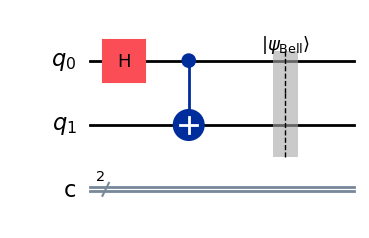

In [9]:
# circuito com 2 qubits (registro quântico) + 2 bits (registro clássico):
qc = QuantumCircuit(2,2)

qc.h(0) # <-- aplicação da porta Hadamard no qubit 0
qc.cx(0,1) # <-- aplicação da porta CNOT (não-controlado), com qubit-0- no controle e qubit-1 no alvo.
qc.barrier(label = r"$|\psi_{\text{Bell}}\rangle$") # <-- barreira com indicação do estado

#impressão do circuito
qc.draw('mpl')

In [10]:
'''
Podemos visualizar o estado criado pelo circuito usando o método Statevector.
Cuidado: o Statevector só aceita circuitos sem medidas (como o circuito acima).
'''

import qiskit.quantum_info as qi

estado = qi.Statevector(qc)
print(">>> Amplitudes de probabilidade (coeficientes na base computacional |00>, |01>, |10>, |11>):")
print(estado)
print(">>> Estado na base computacional, formato Latex:")
display(estado.draw('latex'))

# Probabilidades
probs = estado.probabilities()
print(">>> Probabilidades (quadrados dos módulos das amplitudes de probabilidade):")
print(f"Probabilidades: {probs}")

>>> Amplitudes de probabilidade (coeficientes na base computacional |00>, |01>, |10>, |11>):
Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))
>>> Estado na base computacional, formato Latex:


<IPython.core.display.Latex object>

>>> Probabilidades (quadrados dos módulos das amplitudes de probabilidade):
Probabilidades: [0.5 0.  0.  0.5]


In [11]:
'''
Simulação de experimento pelo método sample

O resultado é armazenado num dicionário com
- keys (senhas) =  índices da base computacional
- values (valores) = o número de vezes que se observou o correspondente elemento da base computacional
'''
shots = 2**10
resultado = estado.sample_counts(shots = shots)
print(resultado)

{np.str_('00'): np.int64(490), np.str_('11'): np.int64(534)}


In [12]:
'''
Pós-processamento

Aqui, vamos extrair as quase-probabilidades produzidas pelo experimento
'''

keys = resultado.keys()
print(f"Senhas : {keys}")
valores = resultado.values()
print(f"Valores: {valores}")
probabilidades = [resultado[key]/shots for key in keys]
print(f"Quase-probabilidades: {probabilidades}")

Senhas : dict_keys([np.str_('00'), np.str_('11')])
Valores: dict_values([np.int64(490), np.int64(534)])
Quase-probabilidades: [np.float64(0.478515625), np.float64(0.521484375)]


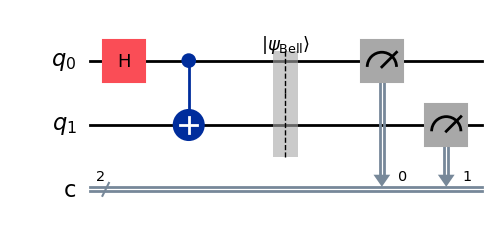

In [13]:
'''
Experimentos

Para realizarmos experimentos reais no circuito quântico, precisamos inserir medidas nele.

'''

qc.measure([0,1], [0,1]) # <-- medida do qubit-k com resultado armazenado no bit-k (k = 0, 1)
qc.draw('mpl')

In [14]:
# Definição do backend:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane # <-- FakeBrisbane simula o processador quântico Brisbane de 127 qubits
backend = FakeBrisbane()

# Transpilação do circuito (reconfiguração adaptada ao processados)
from qiskit.transpiler import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=2, backend = backend)
isa_circuitos = pm.run(qc)

# Experimento via Sampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)

shots = 2**12
job = sampler.run([(isa_circuitos, )], shots = shots)
result = job.result()
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'shots': 4096, 'circuit_metadata': {}})], metadata={'version': 2})


In [15]:
# Extração dos dados (contagens)

counts = result[0].data['c'].get_counts() # <-- infelizmente, o comando é complicado assim...
print(counts)

{'00': 1996, '11': 2015, '10': 30, '01': 55}


In [16]:
# Pós-processamento

keys = counts.keys()
print(f"Senhas : {keys}")
probabilidades = [counts[key]/shots for key in keys]
print(f"Quase-probabilidades: {probabilidades}")

Senhas : dict_keys(['00', '11', '10', '01'])
Quase-probabilidades: [0.4873046875, 0.491943359375, 0.00732421875, 0.013427734375]


# Codificação em Amplitude

Referência:
*   Kosuke Mitarai, Masahiro Kitagawa, Keisuke Fujii: <i>Quantum analog-digital conversion</i>. Phys. Rev. A, v.99, n.012301 [8 pages] (2019). <a href="https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.012301" target = "_blank">10.1103/PhysRevA.99.012301</a>

Dados $N = 2^n$ e uma função com domínio no intervalo de inteiros
$$
f: \left[0,N\right) \rightarrow \left[0,1 \right],\ \ \ \  \left[0,N\right) = \left\{0, 1, 2^n-1\right\},
$$
a codificação em amplitude da função $f$ consiste em um circuito quântico que realiza a seguinte operação, envolvendo um registro quântico princial ($n$ qubits) e um registro quântico auxiliar ($1$ qubit):

$$
\begin{split}
| k \rangle \otimes |0\rangle_a \xrightarrow{\textrm{codificação em aplitude}}& | k \rangle \otimes \left(\sqrt{1-f^2(k)}|0\rangle_a + f(k)|1\rangle_a \right)\\
& = \sqrt{1-f^2(k)}| k \rangle |0\rangle_a + f(k)| k \rangle|1\rangle_a
\end{split}
$$
Observe que o qubit principal não é modificado, mas ele controla a alteração no qubit auxiliar.



### Exemplo: $$f: \left[0,3 \right) \rightarrow \left[0,1\right],\ f(x) = x/3$$

In [17]:
def f(x):
    float(x)
    return x/3

def Tf(x):
    if f(x) == 1:
        return np.pi
    else:
        return 2*np.arctan(f(x)/np.sqrt(1-f(x)**2))

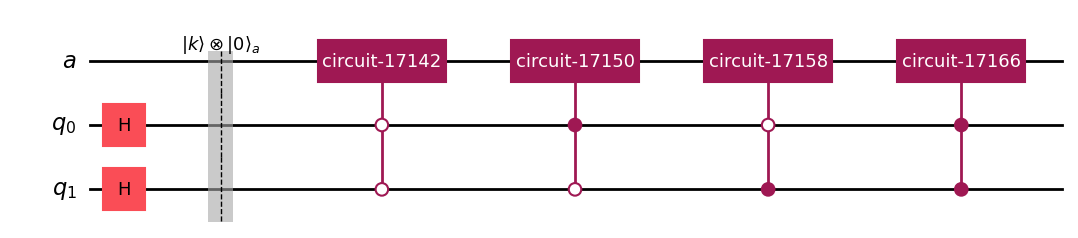

In [99]:
#Circuito quântico
qr = QuantumRegister(2, name="q")
ar = QuantumRegister(1, name="a")
qc = QuantumCircuit(ar,qr)

# Preparação do estado inicial: superposição de todos os estados
qc.h(qr[0])
qc.h(qr[1])

qc.barrier(label = r"$|k\rangle \otimes |0\rangle_a$")

u = [] #<-- Cria a lista de portas controladas
for k in range(4):
    circ = QuantumCircuit(1)
    circ.ry( Tf(k), [0])
    binario = bin(k)[2:].zfill(2)
    circ_controlado = circ.to_gate().control(2, ctrl_state = binario)
    u.append(circ_controlado)

for k in range(4): #<-- aplicação das portas controladas
    qc.append(u[k], [qr[0], qr[1], ar[0]])

qc.draw('mpl')

>>> Estado na base computacional, formato Latex:


<IPython.core.display.Latex object>

{np.str_('000'): np.int64(253), np.str_('010'): np.int64(242), np.str_('011'): np.int64(24), np.str_('100'): np.int64(124), np.str_('101'): np.int64(122), np.str_('111'): np.int64(259)}


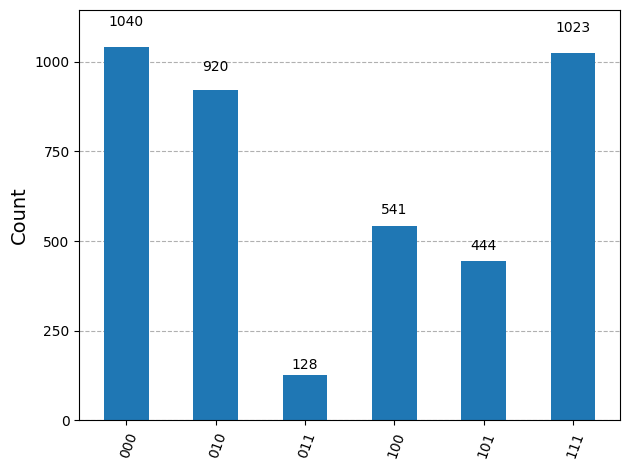

In [100]:
'''
Simulação de experimento
'''


import qiskit.quantum_info as qi

estado = qi.Statevector(qc)
print(">>> Estado na base computacional, formato Latex:")
display(estado.draw('latex'))

shots = 2**12
contagens = estado.sample_counts(shots = shots)
print(resultado)
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
plot_histogram(contagens)

In [101]:
# Pós-processamento
for k in range(4):
    bits = bin(k)[2:].zfill(2)
    key_0 = bits+'0'
    if key_0 in contagens.keys():
        counts_0 =  contagens[bits+'0']
    else:
        counts_0 = 0
    key_1 = bits+'1'
    if key_1 in contagens.keys():
        counts_1 = contagens[bits+'1']
    else:
        counts_1 = 0
    if counts_0 == 0 and counts_1 == 0:
        continue
    print(f"f({k}): {f(k)}. Estimativa: {np.sqrt(counts_1/(counts_0 + counts_1))}")

f(0): 0.0. Estimativa: 0.0
f(1): 0.3333333333333333. Estimativa: 0.3494816226644152
f(2): 0.6666666666666666. Estimativa: 0.6713876833244686
f(3): 1.0. Estimativa: 1.0


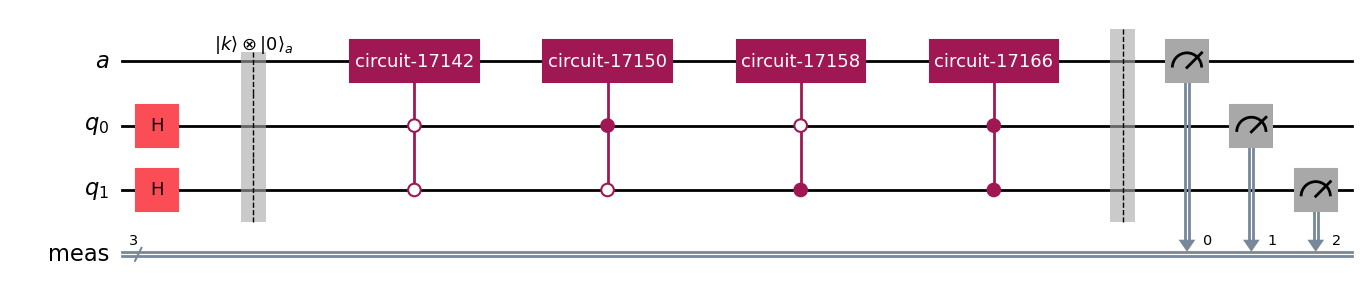

In [102]:
'''
Simulação de experimento no computador quântico
'''

# Medida
qc.measure_all()
display(qc.draw('mpl'))


In [103]:
from qiskit_ibm_runtime.fake_provider import FakeBogotaV2
backend = FakeBogotaV2()

from qiskit.transpiler import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=2, backend = backend)

# Transpilação

isa_circuitos = pm.run(qc)

shots = 2**14

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)
job = sampler.run([(isa_circuitos, )], shots = shots)
experimento = job.result()
print(experimento)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=16384, num_bits=3>)), metadata={'shots': 16384, 'circuit_metadata': {}})], metadata={'version': 2})


{'010': 3165, '101': 1732, '111': 3062, '000': 3639, '100': 2210, '110': 766, '011': 1039, '001': 771}


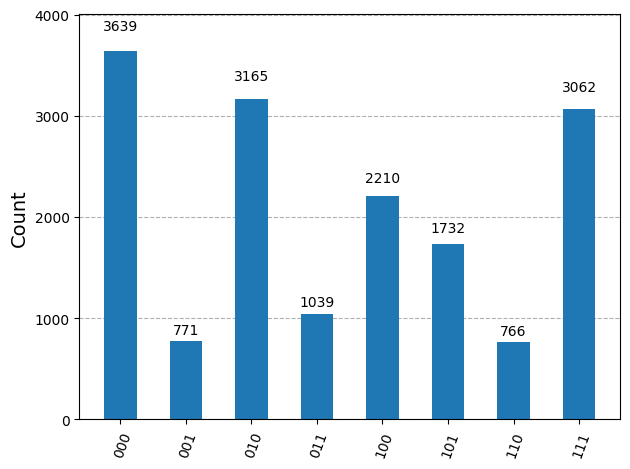

In [104]:
contagens = experimento[0].data['meas'].get_counts()
print(contagens)
from qiskit.visualization import plot_histogram, array_to_latex, plot_state_city
plot_histogram(contagens)

In [105]:
# Pós-processamento
for k in range(4):
    bits = bin(k)[2:].zfill(2)
    key_0 = bits+'0'
    if key_0 in contagens.keys():
        counts_0 =  contagens[bits+'0']
    else:
        counts_0 = 0
    key_1 = bits+'1'
    if key_1 in contagens.keys():
        counts_1 = contagens[bits+'1']
    else:
        counts_1 = 0
    if counts_0 == 0 and counts_1 == 0:
        continue
    print(f"f({k}): {f(k)}. Estimativa: {np.sqrt(counts_1/(counts_0 + counts_1))}")

f(0): 0.0. Estimativa: 0.41812669368600364
f(1): 0.3333333333333333. Estimativa: 0.4971373810550213
f(2): 0.6666666666666666. Estimativa: 0.6628505696814645
f(3): 1.0. Estimativa: 0.8943687756133141
